# Fama and French Factor Model #

### The Model Specification ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data
from capm_toolkit import wexp
from capm_toolkit import capm_regression

In [2]:
# We can download the premiums in the Fama and French website
premiums_df = pd.read_csv(r'..\additional_data\famafrench_premiums.csv')
premiums_df.set_index('Date', inplace=True)
premiums_df.index = pd.to_datetime(premiums_df.index)
premiums_df.columns = ['mkt_premium', 'smb_premium', 'hml_premium', 'risk_free_rate']
premiums_df = premiums_df.div(100)

premiums_df

,mkt_premium,smb_premium,hml_premium,risk_free_rate
Date,,,,
2015-01-02,-0.0012,-0.0059,0.0012,0.00000
2015-01-05,-0.0184,0.0033,-0.0068,0.00000
2015-01-06,-0.0103,-0.0080,-0.0029,0.00000
2015-01-07,0.0119,0.0020,-0.0067,0.00000
2015-01-08,0.0181,-0.0012,-0.0029,0.00000
...,...,...,...,...
2025-03-25,0.0012,-0.0094,0.0005,0.00016
2025-03-26,-0.0122,-0.0048,0.0152,0.00016
2025-03-27,-0.0042,0.0019,0.0030,0.00016


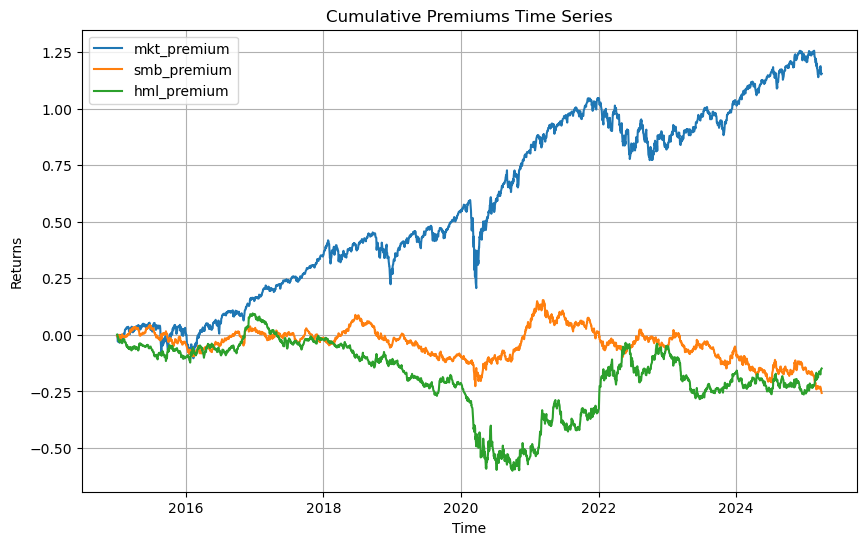

In [3]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(
    premiums_df[['mkt_premium', 'smb_premium', 'hml_premium']].cumsum(), 
    label=premiums_df[['mkt_premium', 'smb_premium', 'hml_premium']].columns, 
    alpha=1
)

# Config
plt.title('Cumulative Premiums Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [4]:
# Get Data from Stock

ticker = 'MSFT'

data_stock = get_market_data(
    ticker=ticker, 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,39.630875,39.973034,39.562441,39.665088,39673900,-0.009238
2015-01-06,39.049194,39.990137,38.955099,39.673639,36447900,-0.014786
2015-01-07,39.545345,39.742088,38.912348,39.331494,29114100,0.012626
2015-01-08,40.708694,40.845559,39.964494,39.990155,29645200,0.028994
2015-01-09,40.366516,40.905422,40.118451,40.725788,23944200,-0.008441
...,...,...,...,...,...,...
2024-12-24,437.647400,437.916385,432.527101,432.985331,7164500,0.009330
2024-12-26,436.432068,439.251246,434.957756,437.398354,8194200,-0.002781
2024-12-27,428.881104,433.553144,424.717120,432.935523,18117700,-0.017453


In [5]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = data_stock.index)

regression_df['stock_premium'] = data_stock['returns'] - premiums_df['risk_free_rate']
regression_df['mkt_premium'] = premiums_df['mkt_premium']
regression_df['smb_premium'] = premiums_df['smb_premium']
regression_df['hml_premium'] = premiums_df['hml_premium']
regression_df.dropna(inplace = True)

regression_df

,stock_premium,mkt_premium,smb_premium,hml_premium
Date,,,,
2015-01-05,-0.009238,-0.0184,0.0033,-0.0068
2015-01-06,-0.014786,-0.0103,-0.0080,-0.0029
2015-01-07,0.012626,0.0119,0.0020,-0.0067
2015-01-08,0.028994,0.0181,-0.0012,-0.0029
2015-01-09,-0.008441,-0.0085,0.0001,-0.0047
...,...,...,...,...
2024-12-24,0.009160,0.0111,-0.0009,-0.0006
2024-12-26,-0.002951,0.0001,0.0104,-0.0019
2024-12-27,-0.017623,-0.0117,-0.0065,0.0057


In [6]:
# Create the Y Vector
y = regression_df['stock_premium']

# Create the X Matrix
x = regression_df[['mkt_premium', 'smb_premium', 'hml_premium']]

In [7]:
x.corr()

,mkt_premium,smb_premium,hml_premium
mkt_premium,1.000000,0.212471,-0.062343
smb_premium,0.212471,1.000000,0.006079
hml_premium,-0.062343,0.006079,1.000000


In [8]:
# Calculate Weights
window = len(y)

# The results of the model
results = capm_regression(
    y,
    x,
    window,
    True
)
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:          stock_premium   R-squared:                       0.722
Model:                            WLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     2179.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:26:50   Log-Likelihood:                 8172.8
No. Observations:                2515   AIC:                        -1.634e+04
Df Residuals:                    2511   BIC:                        -1.631e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0001      0.000      0.744      

In [9]:
# Let us Create a new function
def FamaFrenchFactors(
    stock_returns: pd.Series, 
    market_returns: pd.Series, 
    small_minus_big_series: pd.Series,
    high_minus_low_series: pd.Series,
):

    # Align time series to the same date range
    common_index = stock_returns.index.intersection(market_returns.index) \
    .intersection(small_minus_big_series.index) \
    .intersection(high_minus_low_series.index)
    
    stock_returns = stock_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    small_minus_big_series = small_minus_big_series.loc[common_index]
    high_minus_low_series = high_minus_low_series.loc[common_index]
    
    X = pd.concat([market_returns, small_minus_big_series, high_minus_low_series], axis=1)
    y = stock_returns

    # Create weights with exponential decay
    T = len(y)
    weights = T * wexp(T, T/2)
    
    # Fit WLS regression
    model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

    # Avoid KeyError by checking if params exist
    params = model.params
    
    alpha = params.iloc[0]
    capm_beta = params.iloc[1]
    smb_beta = params.iloc[2]
    hml_beta = params.iloc[3]
            
    parameters = {
        'alpha':alpha,
        'mkt_beta':capm_beta,
        'smb_beta':smb_beta,
        'hml_beta':hml_beta,
    }
    
    return parameters

In [10]:
# Check if the Function Works

parameters = FamaFrenchFactors(
    regression_df['stock_premium'],
    regression_df['mkt_premium'],
    regression_df['smb_premium'],
    regression_df['hml_premium'],
)

parameters

{'alpha': 0.00013406619815620348,
 'mkt_beta': 1.1894117992999462,
 'smb_beta': -0.4368035985564989,
 'hml_beta': -0.45873158345297327}

### Obtaining the Coefficients for all the Stocks ###

In [11]:
# Dictionary to store the DataFrames
returns_df = pd.read_csv(r'..\additional_data\stocks_returns.csv')
returns_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
returns_df.set_index('Date', inplace=True)
returns_df.index = pd.to_datetime(returns_df.index)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018915,-0.028576,-0.018998,0.000222,-0.004989,-0.018352,-0.035215,-0.000721,-0.014722,-0.010052,...,-0.013900,0.000000,-0.017166,-0.011416,-0.027743,-0.064259,-0.020527,0.036625,-0.014177,-0.006022
2015-01-06,-0.015700,0.000094,-0.004962,-0.011421,-0.020350,-0.023753,-0.019911,-0.008324,-0.019973,-0.011709,...,-0.017255,-0.001108,-0.021562,0.005306,-0.005330,-0.005898,-0.012351,-0.008513,-0.007231,-0.009804
2015-01-07,0.013184,0.013925,0.039621,0.008076,0.008190,0.010462,0.014920,0.008685,-0.002089,0.007747,...,0.016088,0.003045,0.028945,0.008598,0.010081,0.007857,0.032601,0.024566,0.025146,0.020432
2015-01-08,0.029534,0.037702,0.010404,0.020345,0.025135,0.017501,-0.014717,0.022681,0.024446,0.003522,...,0.019467,0.010722,0.011959,0.011532,0.016508,0.007517,0.017270,0.010561,0.021134,0.015282
2015-01-09,-0.007364,0.001072,-0.027736,-0.010563,-0.014922,-0.000731,-0.008566,-0.007188,-0.009054,-0.011270,...,-0.011519,-0.001368,0.012422,-0.012361,-0.001411,-0.019043,-0.001768,-0.014529,0.014508,0.001583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011083,0.011413,0.008985,0.003929,0.002683,0.014782,0.004355,0.007822,0.012494,0.013291,...,0.009663,0.006390,0.007575,0.007210,0.000940,0.005432,0.008480,0.004484,0.012187,0.002553
2024-12-26,-0.001986,0.003171,-0.004454,0.004434,0.004944,-0.000138,-0.000395,0.002594,-0.003159,-0.002203,...,0.001981,-0.003190,0.005952,-0.000440,0.000845,0.002705,0.007380,-0.000466,0.003559,0.004966
2024-12-27,-0.002137,-0.013331,-0.006663,-0.002432,-0.008208,-0.004919,-0.000593,-0.003539,-0.008999,-0.006305,...,-0.000630,-0.006410,-0.007079,-0.000587,-0.000094,-0.007966,-0.005678,-0.003549,-0.019799,-0.005574


In [12]:
# Calculate the Coefficients
tickers = []
betas_capm = []
betas_smb = []
betas_hml = []

# Create the Loop
for ticker in returns_df.columns:
    stock_excess_returns = returns_df[ticker] - premiums_df['risk_free_rate']

    # Calculations
    parameters = FamaFrenchFactors(
        stock_excess_returns,
        premiums_df['mkt_premium'],
        premiums_df['smb_premium'],
        premiums_df['hml_premium'],
    )

    tickers.append(ticker)
    betas_capm.append(parameters['mkt_beta'])
    betas_smb.append(parameters['smb_beta'])
    betas_hml.append(parameters['hml_beta'])

    print(f'{ticker} is ready.')

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [13]:
# Create the DataFrame

ff_betas_df = pd.DataFrame(
    {
        'mkt_beta': betas_capm,
        'smb_beta': betas_smb,
        'hml_beta': betas_hml
    }, index = tickers,
)

ff_betas_df

,mkt_beta,smb_beta,hml_beta
A,0.955686,0.079807,-0.134990
AAPL,1.161827,-0.290220,-0.378872
ABBV,0.616293,-0.301336,0.108055
ABT,0.786172,-0.290043,-0.130577
ADBE,1.253717,-0.235385,-0.681084
...,...,...,...
XYL,1.039345,0.146356,0.256511
YUM,0.760846,-0.183805,0.146926
ZBH,0.830569,0.124457,0.241640
ZBRA,1.267471,0.503546,-0.076601


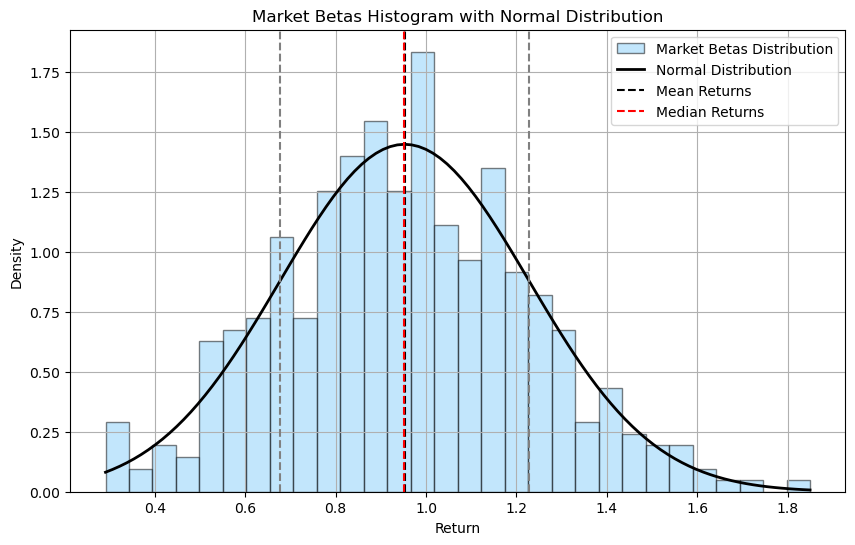

In [14]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['mkt_beta'].mean()
sigma = ff_betas_df['mkt_beta'].std()
median = ff_betas_df['mkt_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['mkt_beta'], bins=30, density=True, color='lightskyblue', alpha=0.5, edgecolor='black', label='Market Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['mkt_beta'].min(), ff_betas_df['mkt_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('Market Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

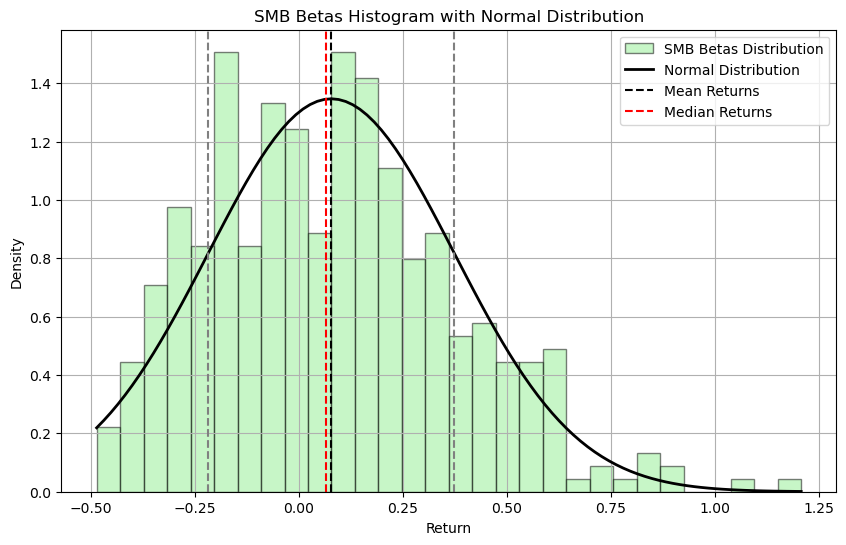

In [15]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['smb_beta'].mean()
sigma = ff_betas_df['smb_beta'].std()
median = ff_betas_df['smb_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['smb_beta'], bins=30, density=True, color='lightgreen', alpha=0.5, edgecolor='black', label='SMB Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['smb_beta'].min(), ff_betas_df['smb_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('SMB Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

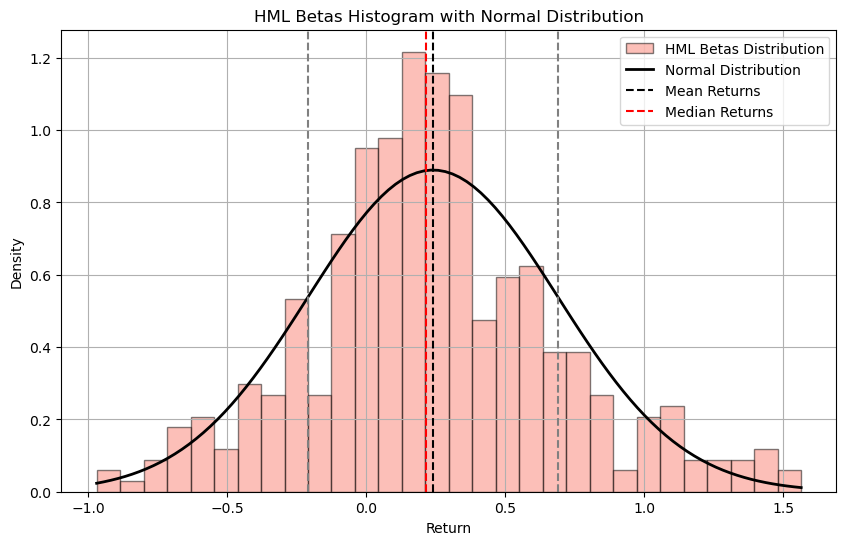

In [16]:
# Calculate Mean and Standard Deviation
mu = ff_betas_df['hml_beta'].mean()
sigma = ff_betas_df['hml_beta'].std()
median = ff_betas_df['hml_beta'].median()

# Create Histogram
plt.figure(figsize=(10, 6))
plt.hist(ff_betas_df['hml_beta'], bins=30, density=True, color='salmon', alpha=0.5, edgecolor='black', label='HML Betas Distribution')

# Generate the Values of the Normal Distribution
x = np.linspace(ff_betas_df['hml_beta'].min(), ff_betas_df['hml_beta'].max(), 100)
y = norm.pdf(x, mu, sigma)

# Graph the Real Normal Distribution
plt.plot(x, y, color='black', linestyle='solid', linewidth=2, label='Normal Distribution')

# Reference Lines
plt.axvline(x=mu, color='black', linestyle='dashed', label='Mean Returns')
plt.axvline(x=median, color='red', linestyle='dashed', label='Median Returns')
plt.axvline(x=mu + sigma, color='grey', linestyle='dashed')
plt.axvline(x=mu - sigma, color='grey', linestyle='dashed')

# Config
plt.title('HML Betas Histogram with Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')

# Legends and Grid
plt.legend()
plt.grid(True)

# Show
plt.show()

In [17]:
# Calculate the VIF
# Concat
X = pd.concat([
    regression_df['mkt_premium'],
    regression_df['smb_premium'],
    regression_df['hml_premium'],
], axis=1, join='inner')


X.dropna(inplace = True)

X.columns = ['mkt', 'smb', 'hml']

X

,mkt,smb,hml
Date,,,
2015-01-05,-0.0184,0.0033,-0.0068
2015-01-06,-0.0103,-0.0080,-0.0029
2015-01-07,0.0119,0.0020,-0.0067
2015-01-08,0.0181,-0.0012,-0.0029
2015-01-09,-0.0085,0.0001,-0.0047
...,...,...,...
2024-12-24,0.0111,-0.0009,-0.0006
2024-12-26,0.0001,0.0104,-0.0019
2024-12-27,-0.0117,-0.0065,0.0057


In [18]:
vif_data = pd.DataFrame()
vif_data['vars'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,vars,VIF
0,mkt,1.051532
1,smb,1.047434
2,hml,1.004352


In [19]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = X.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

,vars,r_squared
0,mkt,0.049007
1,smb,0.045286
2,hml,0.004333


In [68]:
ff_betas_df.to_csv(r"..\additional_data\famafrench_betas.csv")